### Parametric Models 

In [70]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pandas.plotting import register_matplotlib_converters
from pmdarima import auto_arima
from prophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
import numpy as np
import pandas as pd
import os

# Load the provided Excel file
file_path = 'MMM_Blender_data_2.xlsx'
data = pd.read_excel(file_path)

#Create a blank dataframe for the calculations
df_total = pd.DataFrame()

# Display the first few rows
data.head(10)

,Date,Sales ($),TV_ads ($),online_ads ($),Print_ads ($),Price ($)
0,Jan-2008,6237000,181222.548442,12152.540107,24986.912760,135.0
1,Feb-2008,6115500,179104.353164,57353.376363,17574.385360,135.0
2,Mar-2008,10577250,222756.223235,146794.245435,16016.022899,135.0
3,Apr-2008,13473000,188266.818315,376459.468169,29689.694160,135.0
4,May-2008,6258525,210038.289741,21297.573231,17606.991440,136.5
5,Jun-2008,7371000,196292.677236,80514.079702,20905.296790,136.5
6,Jul-2008,8060325,183358.262369,120537.488441,20116.497418,136.5
7,Aug-2008,10278450,192723.580333,218782.364044,17642.672293,136.5
8,Sep-2008,10991700,200450.916640,248129.090562,18509.452326,138.0
9,Oct-2008,9618600,182675.622775,201009.441600,23807.248992,138.0


In [71]:
#Rename columns for a better handling in the model am graphic
data = data.rename(columns={'Sales ($)':'Sales','TV_ads ($)':'TV_ads','online_ads ($)':'Online_ads','Print_ads ($)':'Print_ads','Price ($)':'Price'})
data2 = data.rename(columns={'Sales ($)':'Sales','TV_ads ($)':'TV_ads','online_ads ($)':'Online_ads','Print_ads ($)':'Print_ads','Price ($)':'Price'})
data.describe() 

,Sales,TV_ads,Online_ads,Print_ads,Price
count,1.500000e+02,150.000000,150.000000,150.000000,150.000000
mean,7.387596e+06,200172.675917,123295.713622,19780.483463,158.150000
std,2.794341e+06,9486.447152,88241.498625,4875.143064,13.732799
min,7.854000e+05,176450.216326,876.373521,4716.529170,135.000000
25%,5.835769e+06,193755.149356,54933.854835,16695.656714,145.875000
50%,7.635600e+06,199504.100334,104538.370602,19926.875169,158.250000
75%,9.482625e+06,206391.579637,172074.250144,22933.492770,169.500000
max,1.380225e+07,222756.223235,442144.852073,32794.574130,180.000000


In [72]:
# Develop table to insert the values per model 
def Record_values(df,model,AIC,BIC,R2,MSE,MAPD):
    new_record=pd.DataFrame({
            'Model Name':[model],
            'AIC Value':[AIC],
            'BIC Value':[BIC],
            'R2 Value':[R2],
            'MSE Value':[MSE],
            'MAPD Value':[MAPD]
    })
    return pd.concat([df, new_record], ignore_index=True)

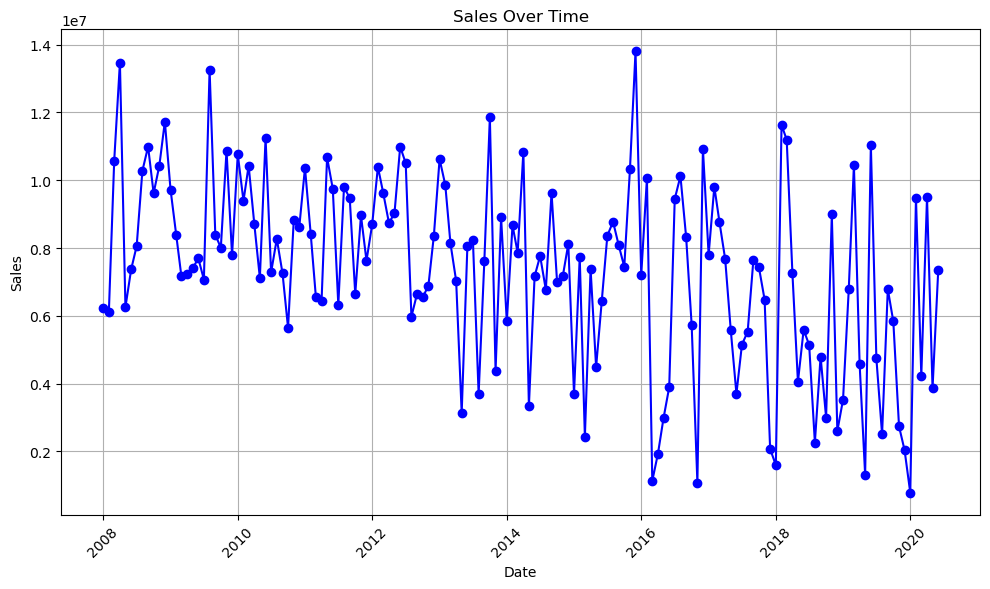

In [73]:
register_matplotlib_converters()

# Convert the 'Date' column to datetime format for better plotting
data['Date'] = pd.to_datetime(data['Date'], format='%b-%Y')

# Plotting Sales over Time
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Sales'], marker='o', linestyle='-', color='b')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


###  Linear Regression, Ridge, and Lasso Regression Models 

In [74]:
#Developing a Linear regression model 
# Selecting the features (independent variables) and the target (dependent variable)
# Convert 'Date' column to datetime and set it as the index
data['Date'] = pd.to_datetime(data['Date'], format='%b-%Y')
data.set_index('Date', inplace=True)

# Define features and target variable
X = data[['TV_ads', 'Online_ads', 'Print_ads', 'Price']]
y = data['Sales']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Initialize the models
linear_model = LinearRegression()
ridge_model = Ridge()
lasso_model = Lasso()


# Train the models
linear_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_linear = linear_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)

# Calculate Mean Squared Error for each model
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)


# Calculate R2 Score for each model
r2_linear = r2_score(y_test, y_pred_linear)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)


# Number of observations and number of parameters (including intercept)
n = len(y_test)
k = X_train.shape[1] + 1  # Adding 1 for the intercept

# Residual sum of squares (RSS)
RSS_linear= mse_linear * n
RSS_ridge = mse_ridge * n
RSS_lasso = mse_lasso * n

# Calculate AIC Score for each model
AIC_linear = n * np.log(RSS_linear / n) + 2 * k
AIC_ridge = n * np.log(RSS_ridge / n) + 2 * k
AIC_lasso = n * np.log(RSS_lasso / n) + 2 * k

# Calculate BIC Score for each model
BIC_linear = n * np.log(RSS_linear / n) + k * np.log(n)
BIC_ridge  = n * np.log(RSS_ridge / n) + k * np.log(n)
BIC_lasso  = n * np.log(RSS_lasso / n) + k * np.log(n)

# Calculate MAPD score for each model
MAPD_linear = np.mean(np.abs((y_test - y_pred_linear) / y_test)) * 100
MAPD_ridge  = np.mean(np.abs((y_test - y_pred_ridge) / y_test)) * 100
MAPD_lasso  = np.mean(np.abs((y_test - y_pred_lasso) / y_test)) * 100


#Saving values about the model for future comparasion
test= Record_values(df_total,'Linear Regression',AIC_linear,BIC_linear,r2_linear,mse_linear,MAPD_linear)
test= Record_values(test,'Ridge Regression',AIC_ridge,BIC_ridge,r2_ridge,mse_ridge,MAPD_ridge)
test= Record_values(test,'Lasso Regression',AIC_lasso,BIC_lasso,r2_lasso,mse_lasso,MAPD_lasso)
test.head(10)

,Model Name,AIC Value,BIC Value,R2 Value,MSE Value,MAPD Value
0,Linear Regression,843.629567,850.635554,0.883201,1.169564e+12,37.196402
1,Ridge Regression,843.632365,850.638352,0.883190,1.169673e+12,37.198339
2,Lasso Regression,843.629573,850.635560,0.883201,1.169564e+12,37.196406


### SARIMAX Model 
#### Assuming no seasonality and a simple ARIMA(1,1,1) model

In [75]:
# Implementing a Dynamic Regression Model (SARIMAX) with exogenous variables

# Define the exogenous variables (advertising expenditures and price)
exog = data[['TV_ads', 'Online_ads', 'Print_ads', 'Price']]

# Define the SARIMAX model with ARIMA components
# Assuming no seasonality and a simple ARIMA(1,1,1) model
sarimax_model = SARIMAX(y, exog=exog, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)

# Fit the model
sarimax_results = sarimax_model.fit(disp=False)

# Extracting AIC and BIC from the fitted SARIMAX model
aic_SAR = sarimax_results.aic
bic_SAR = sarimax_results.bic

# Predicting the sales using the fitted SARIMAX model
predicted_sales = sarimax_results.predict(start=data.index[0], end=data.index[-1], exog=exog)

# Calculating R-squared
r2_SAR = r2_score(y, predicted_sales)

# Calculating Mean Squared Error (MSE)
mse_SAR = mean_squared_error(y, predicted_sales)

# Calculating Mean Absolute Percentage Deviation (MAPD)
mapd_SAR = mean_absolute_percentage_error(y, predicted_sales)

#Saving values about the model for future comparasion
test= Record_values(test,'SARIMAX',aic_SAR,bic_SAR,r2_SAR,mse_SAR,mapd_SAR)
test.head(10)


c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Model Name,AIC Value,BIC Value,R2 Value,MSE Value,MAPD Value
0,Linear Regression,843.629567,850.635554,0.883201,1.169564e+12,37.196402
1,Ridge Regression,843.632365,850.638352,0.883190,1.169673e+12,37.198339
2,Lasso Regression,843.629573,850.635560,0.883201,1.169564e+12,37.196406
3,SARIMAX,4433.838306,4454.771335,0.914982,6.594226e+11,0.149970


### ETS Model 

In [76]:
# Implementing the ETS model (Exponential Smoothing with trend and seasonality)
ets_model = ExponentialSmoothing(y, trend='additive', seasonal=None, damped_trend=False)
                                 
# Fitting the model
ets_results = ets_model.fit()

# Extracting AIC and BIC from the fitted SARIMAX model
aic_ETS = ets_results.aic
bic_ETS = ets_results.bic

# Generate predictions using the ETS model
ets_predictions = ets_results.fittedvalues

# Calculating R-squared
r2_ETS = r2_score(y, ets_predictions)

# Calculating Mean Squared Error (MSE)
mse_ETS = mean_squared_error(y, ets_predictions)

# Calculating Mean Absolute Percentage Deviation (MAPD)
mapd_ETS = mean_absolute_percentage_error(y, ets_predictions)

#Saving values about the model for future comparasion
test= Record_values(test,'ETS',aic_ETS,bic_ETS,r2_ETS,mse_ETS,mapd_ETS)
test.head(10)

c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,Model Name,AIC Value,BIC Value,R2 Value,MSE Value,MAPD Value
0,Linear Regression,843.629567,850.635554,0.883201,1.169564e+12,37.196402
1,Ridge Regression,843.632365,850.638352,0.883190,1.169673e+12,37.198339
2,Lasso Regression,843.629573,850.635560,0.883201,1.169564e+12,37.196406
3,SARIMAX,4433.838306,4454.771335,0.914982,6.594226e+11,0.149970
4,ETS,4451.560579,4463.603120,0.054260,7.335430e+12,0.493568


### Prophet Model

In [77]:
# Prepare the data for the Prophet model
# Prophet requires the dataframe to have specific column names: 'ds' for date and 'y' for the metric to forecast
df_prophet = data2[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Convert the 'ds' column to datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%b-%Y')

# Initialize the Prophet model
model = Prophet()

# Fit the model
model.fit(df_prophet)

# Create a dataframe for future dates, extending the forecast horizon
future = model.make_future_dataframe(periods=12, freq='M')

# Make predictions
forecast = model.predict(future)

# Calculate AIC and BIC
n = len(df_prophet)
k = len(model.params)  # Number of parameters
residuals = df_prophet['y'] - forecast.loc[:len(df_prophet)-1, 'yhat']

# Variance of the residuals
residual_var = np.var(residuals)

# Log likelihood
log_likelihood = -n/2 * (np.log(2 * np.pi) + np.log(residual_var) + 1)

# AIC
aic_PRO = 2*k - 2*log_likelihood

# BIC
bic_PRO = np.log(n)*k - 2*log_likelihood

# Calculate R^2
r2_PRO = r2_score(df_prophet['y'], forecast.loc[:len(df_prophet)-1, 'yhat'])

# Calculate MSE
mse_PRO = mean_squared_error(df_prophet['y'], forecast.loc[:len(df_prophet)-1, 'yhat'])

# Calculate MAPD
mapd_PRO = np.mean(np.abs((df_prophet['y'] - forecast.loc[:len(df_prophet)-1, 'yhat']) / df_prophet['y'])) * 100

#Saving values about the model for future comparasion
test= Record_values(test,'PROPHET',aic_PRO,bic_PRO,r2_PRO,mse_PRO,mapd_PRO)
test.head(10)

20:44:02 - cmdstanpy - INFO - Chain [1] start processing
20:44:03 - cmdstanpy - INFO - Chain [1] done processing


,Model Name,AIC Value,BIC Value,R2 Value,MSE Value,MAPD Value
0,Linear Regression,843.629567,850.635554,0.883201,1.169564e+12,37.196402
1,Ridge Regression,843.632365,850.638352,0.883190,1.169673e+12,37.198339
2,Lasso Regression,843.629573,850.635560,0.883201,1.169564e+12,37.196406
3,SARIMAX,4433.838306,4454.771335,0.914982,6.594226e+11,0.149970
4,ETS,4451.560579,4463.603120,0.054260,7.335430e+12,0.493568
5,PROPHET,4839.786946,4860.861393,0.292119,5.490531e+12,42.575961


### Develop a SARIMAX TUNNED
#### Apply this specific parameters order=(2, 0, 2), seasonal_order=(2, 0, 2, 12)

In [78]:
import pmdarima as pm
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt

# Define the exogenous variables (advertising expenditures and price)
exog = data[['TV_ads', 'Online_ads', 'Print_ads', 'Price']]

# Extract the 'Sales ($)' column for time series analysis
y = data['Sales']

# Define the SARIMAX model with ARIMA components
sarimax_model = SARIMAX(y, exog=exog, order=(2, 0, 2), seasonal_order=(2, 0, 2, 12))

#(2, 0, 2), (2, 0, 2, 12)
# Fit the best model suggested by auto_arima
#sarimax_model = SARIMAX(y, exog=exog, order=auto_model.order, seasonal_order=(2, 0, 2, 12))

# Fit the model
sarimax_results = sarimax_model.fit(disp=False)

# Extracting AIC and BIC from the fitted SARIMAX model
aic_SAR = sarimax_results.aic
bic_SAR = sarimax_results.bic

# Predicting the sales using the fitted SARIMAX model
predicted_sales = sarimax_results.predict(start=data.index[0], end=data.index[-1], exog=exog)

# Calculating R-squared
r2_SAR = r2_score(y, predicted_sales)

# Calculating Mean Squared Error (MSE)
mse_SAR = mean_squared_error(y, predicted_sales)

# Calculating Mean Absolute Percentage Deviation (MAPD)
mapd_SAR = mean_absolute_percentage_error(y, predicted_sales)

#Saving values about the model for future comparasion
test= Record_values(test,'SARIMAX TUNNED',aic_SAR,bic_SAR,r2_SAR,mse_SAR,mapd_SAR)


# Function to highlight a specific row
def highlight_row(row):
    if row.name == 6:  # Change this condition as needed
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)

# Apply the function to the DataFrame
styled_df = test.style.apply(highlight_row, axis=1)

#Display final dataframe with the values.
styled_df


c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Carlos\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Model Name,AIC Value,BIC Value,R2 Value,MSE Value,MAPD Value
0,Linear Regression,843.629567,850.635554,0.883201,1169564118902.361084,37.196402
1,Ridge Regression,843.632365,850.638352,0.883190,1169673190648.341064,37.198339
2,Lasso Regression,843.629573,850.635560,0.883201,1169564323517.227539,37.196406
3,SARIMAX,4433.838306,4454.771335,0.914982,659422592052.086914,0.149970
4,ETS,4451.560579,4463.603120,0.054260,7335430333669.877930,0.493568
5,PROPHET,4839.786946,4860.861393,0.292119,5490530739347.552734,42.575961
6,SARIMAX TUNNED,4517.362055,4556.500314,0.923922,590085181797.533447,0.142034


### Graphic Representation

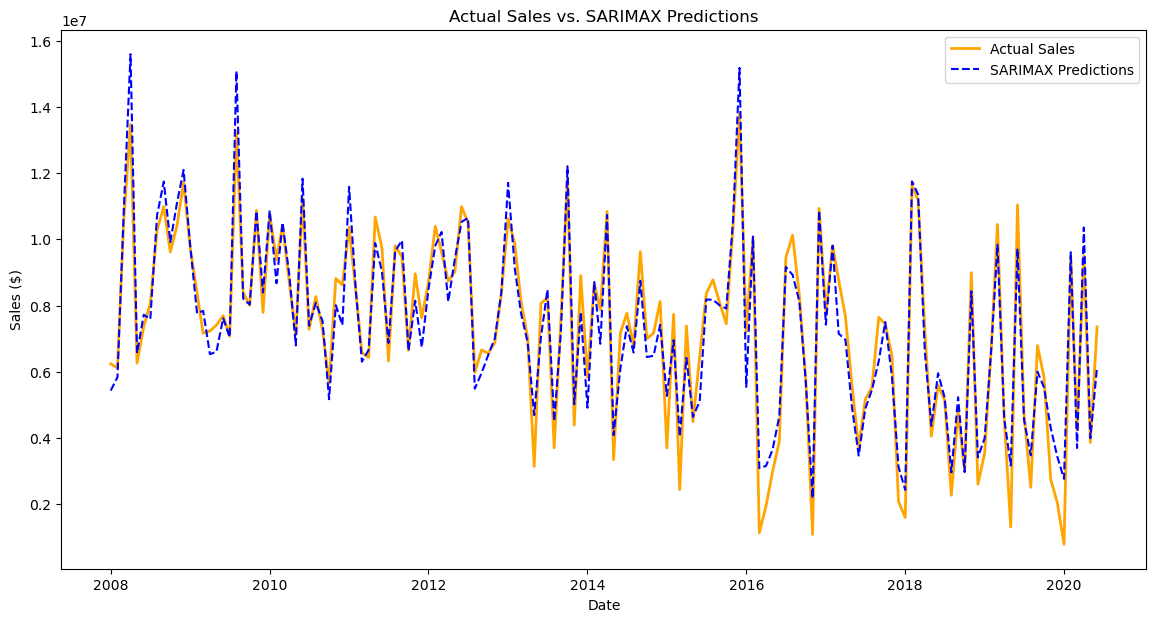

In [79]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, y, label='Actual Sales', color='orange', linewidth=2)
plt.plot(data.index, predicted_sales, label='SARIMAX Predictions', linestyle='--', color='blue')
plt.title('Actual Sales vs. SARIMAX Predictions')
plt.xlabel('Date')
plt.ylabel('Sales ($)')
plt.legend()
plt.show()